## Data Loading and Cleaning

In [23]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Load data and ensure 'user' is treated as string; drop rows without a user id
data = pd.read_csv("data.csv")
data = data.dropna(subset=['user'])
data['user'] = data['user'].astype(str).str.strip()
data = data[data['user'] != '']

# Create a robust 'date' column from time_year and time_month (day set to 1)
data['time_year'] = pd.to_numeric(data.get('time_year', None), errors='coerce')
data['time_month'] = pd.to_numeric(data.get('time_month', None), errors='coerce')
data['date'] = pd.to_datetime(
    data['time_year'].fillna(0).astype(int).astype(str) + '-' +
    data['time_month'].fillna(1).astype(int).astype(str) + '-01',
    errors='coerce'
)
# drop rows with invalid date
data = data.dropna(subset=['date'])
# create a monthly period column for grouping
data['period'] = data['date'].dt.to_period('M')

# Quick checks
data.info()
data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34475 entries, 0 to 34474
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cohort        34475 non-null  int64         
 1   user          34475 non-null  object        
 2   time_year     34475 non-null  int64         
 3   time_month    34475 non-null  int64         
 4   subscription  34475 non-null  int64         
 5   content       34059 non-null  float64       
 6   genres        34059 non-null  float64       
 7   recency_new   34059 non-null  float64       
 8   bounce        34059 non-null  float64       
 9   date          34475 non-null  datetime64[ns]
 10  period        34475 non-null  period[M]     
dtypes: datetime64[ns](1), float64(4), int64(4), object(1), period[M](1)
memory usage: 2.9+ MB


,cohort,user,time_year,time_month,subscription,content,genres,recency_new,bounce,date,period
count,34475.000000,34475,34475.000000,34475.000000,34475.0,34059.000000,34059.000000,34059.000000,34059.000000,34475,34475
unique,NaN,21440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
top,NaN,1291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02
freq,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3400
mean,5.396461,NaN,2017.380595,6.294329,1.0,3.873249,1.885258,0.371159,0.449736,2017-10-27 04:39:51.298041856,NaN
min,0.000000,NaN,2017.000000,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,2017-05-01 00:00:00,NaN
25%,2.000000,NaN,2017.000000,3.000000,1.0,2.000000,1.000000,0.000000,0.000000,2017-08-01 00:00:00,NaN
50%,6.000000,NaN,2017.000000,6.000000,1.0,3.000000,2.000000,0.333300,0.500000,2017-11-01 00:00:00,NaN
75%,8.000000,NaN,2018.000000,9.000000,1.0,5.000000,2.000000,0.636400,0.692300,2018-02-01 00:00:00,NaN
max,11.000000,NaN,2018.000000,12.000000,1.0,81.000000,5.000000,1.000000,1.000000,2018-04-01 00:00:00,NaN


* Total number of unique users
* New users per month
* Active users per month
* Churned users per month
* Retention rate per month
* Average expected lifetime (in months)
* Distribution summary (% of users active after 3 months, 6 etc)
* Survival Probabilities

## Total number of unique users

In [24]:
# Total unique users in dataset
unique_users = data['user'].nunique()

print("Total unique users:" , unique_users)


Total unique users: 21440


## New users per month (cohort)

In [25]:
# New users per cohort 
#( 'cohort' represents acquisition month

# remove duplicates and then  count per cohort
new_users = data.drop_duplicates(subset=['user']).groupby('cohort')['user'].nunique().sort_index()

print("Total new users per cohort: ")
print(new_users)

Total new users per cohort: 
cohort
0     1791
1     2120
2     1268
3     1788
4     1367
5     1761
6     1806
7     1565
8     1967
9     2066
10    1602
11    2339
Name: user, dtype: int64


## Active Users per month 

In [26]:
# Active users per month using 'period' and 'content' >= 1
active_users = (
    data[ data['content'].fillna(0) >= 1 ]
    .groupby('period')['user']
    .nunique()
    .sort_index()
)
print(active_users)

period
2017-05    1791
2017-06    3152
2017-07    2817
2017-08    2643
2017-09    2528
2017-10    2464
2017-11    2647
2017-12    3040
2018-01    3201
2018-02    3361
2018-03    3144
2018-04    3271
Freq: M, Name: user, dtype: int64


## Churned and retained users per month

In [27]:
# Calcolo churn + retention per period usando 'date'/'period' (fix creazione 'date')
import numpy as np

# Non ricaricare data se già presente; assicurati che time_year/time_month siano numerici
data['time_year'] = pd.to_numeric(data.get('time_year'), errors='coerce')
data['time_month'] = pd.to_numeric(data.get('time_month'), errors='coerce')

# Crea colonna 'date' in modo robusto: usa solo righe con year e month validi
valid = data['time_year'].notna() & data['time_month'].notna()
if valid.any():
    data.loc[valid, 'date'] = pd.to_datetime({
        'year': data.loc[valid, 'time_year'].astype(int),
        'month': data.loc[valid, 'time_month'].astype(int),
        'day': 1
    }, errors='coerce')

data = data.dropna(subset=['date'])  # rimuovi righe senza data valida
data['period'] = data['date'].dt.to_period('M')

# Serie: per ogni period gli user con subscription==1 (array di user unici)
subscribed_by_period = (
    data[data['subscription'] == 1]
    .groupby('period')['user']
    .unique()
    .sort_index()
)

# Itera sui period effettivamente presenti e usa period + 1 (gestisce anno)
periods = list(subscribed_by_period.index.sort_values())
rows = []
for p in periods:
    curr = set(subscribed_by_period.loc[p])
    total = len(curr)
    next_p = p + 1  # pandas.Period addition: aggiunge un mese e gestisce cambio anno
    if next_p in subscribed_by_period.index:
        nxt = set(subscribed_by_period.loc[next_p])
        retained = len(curr & nxt)
        churned = len(curr - nxt)
        retention_rate = retained / total if total > 0 else np.nan
        churn_rate = churned / total if total > 0 else np.nan
    else:
        # se non abbiamo dati per il mese successivo non stimiamo retention/churn
        retained = np.nan
        churned = np.nan
        retention_rate = np.nan
        churn_rate = np.nan
    rows.append({
        'period': p,
        'total_users': total,
        'retained_users': retained,
        'churned_users': churned,
        'retention_rate': retention_rate,
        'churn_rate': churn_rate
    })

churn_dataframe = pd.DataFrame(rows).set_index('period').sort_index()

# Aggiungi nome mese per leggibilità (es: 'January')
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
churn_dataframe['month_name'] = [month_names[p.to_timestamp().month - 1] for p in churn_dataframe.index]

# Converti rates in percentuali più leggibili
churn_dataframe['retention_rate_pct'] = (churn_dataframe['retention_rate'] * 100).round(1)
churn_dataframe['churn_rate_pct'] = (churn_dataframe['churn_rate'] * 100).round(1)

print('Churn/retention calcolati usando period + 1 month (gestito anno).')
print(churn_dataframe[['total_users','retained_users','churned_users','retention_rate_pct','churn_rate_pct','month_name']])

Churn/retention calcolati usando period + 1 month (gestito anno).
         total_users  retained_users  churned_users  retention_rate_pct  \
period                                                                    
2017-05         1791          1055.0          736.0                58.9   
2017-06         3175          1597.0         1578.0                50.3   
2017-07         2865           908.0         1957.0                31.7   
2017-08         2696          1190.0         1506.0                44.1   
2017-09         2557           732.0         1825.0                28.6   
2017-10         2493           890.0         1603.0                35.7   
2017-11         2696          1516.0         1180.0                56.2   
2017-12         3081          1265.0         1816.0                41.1   
2018-01         3232          1334.0         1898.0                41.3   
2018-02         3400          1588.0         1812.0                46.7   
2018-03         3190           960

## Average Expected Lifetime

average expted lifetime calculated as last month of activity per user - first month of activity.

**key assumption**: the user does not return after the last observed month.

Average lifetime (months): 1.6079757462686568
Median lifetime (months): 2.0


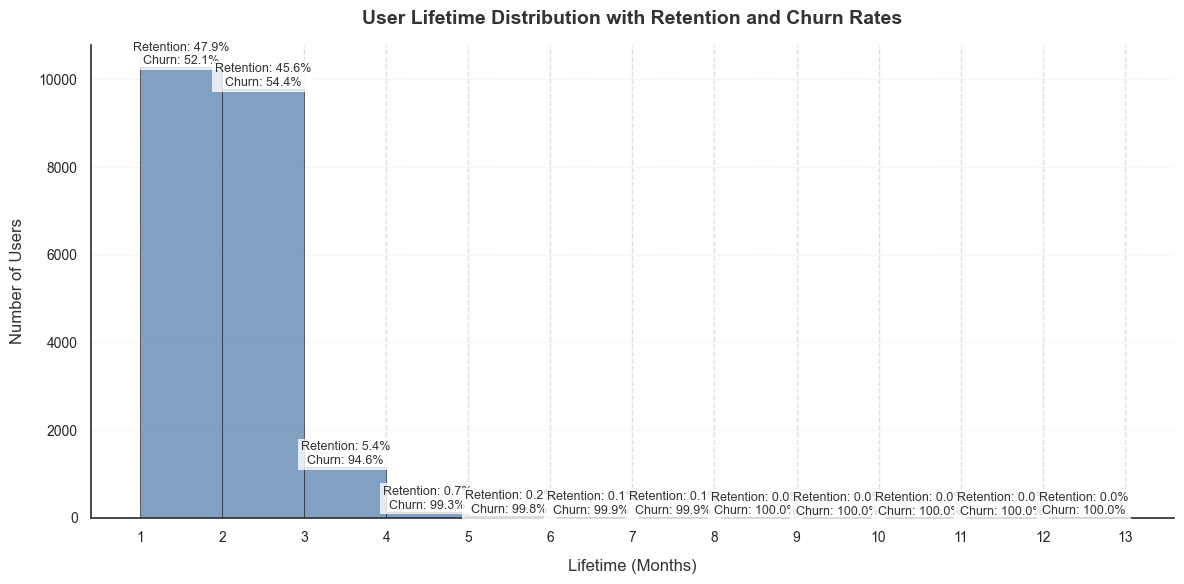

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# use cleaned dataframe 'data' with 'date' column
df = data.dropna(subset=['user','date']).copy()
df['period'] = df['date'].dt.to_period('M')

# primo e ultimo period osservato per user
first_period = df.groupby('user')['date'].min()
last_period = df.groupby('user')['date'].max()

lifetime_months = (last_period.dt.year - first_period.dt.year) * 12 + (last_period.dt.month - first_period.dt.month) + 1

average_lifetime = lifetime_months.mean()
median_lifetime = lifetime_months.median()
print('Average lifetime (months):', average_lifetime)
print('Median lifetime (months):', median_lifetime)

# Calculate retention and churn rates
total_users = len(lifetime_months)
retention_counts = lifetime_months.value_counts().sort_index()
retention_rates = retention_counts / total_users * 100
churn_rates = 100 - retention_rates

# Plot enhanced figure with retention and churn rates
plt.figure(figsize=(12, 6), dpi=100)
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.color": "#e0e0e0"})

# Histogram with enhanced styling
bars = sns.histplot(lifetime_months.dropna(), bins=range(1, int(lifetime_months.dropna().max()) + 2), 
                    kde=False, color='#4C78A8', edgecolor='white', alpha=0.7)

# Add retention and churn rate annotations
for i, bar in enumerate(bars.patches):
    height = bar.get_height()
    months = i + 1
    if months in retention_rates:
        retention = retention_rates[months]
        churn = churn_rates[months]
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5,
                f'Retention: {retention:.1f}%\nChurn: {churn:.1f}%',
                ha='center', va='bottom', fontsize=9, color='#333333',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2))

# Customize plot aesthetics
plt.title('User Lifetime Distribution with Retention and Churn Rates', 
         fontsize=14, pad=15, weight='bold', color='#333333')
plt.xlabel('Lifetime (Months)', fontsize=12, labelpad=10, color='#333333')
plt.ylabel('Number of Users', fontsize=12, labelpad=10, color='#333333')
plt.xticks(range(1, int(lifetime_months.dropna().max()) + 2), fontsize=10)
plt.yticks(fontsize=10)

# Add subtle shadow effect to bars
for bar in bars.patches:
    bar.set_zorder(2)
    bar.set_edgecolor('#333333')
    bar.set_linewidth(0.5)

# Customize spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#333333')
ax.spines['bottom'].set_color('#333333')

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.3)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Quick script to see users with longer lifetime

edit the "threshold" variable and set the number of days.
the script return the users with a lifetime bigger than that.



In [29]:
lifetime = (last_period - first_period) + pd.Timedelta(days=31)

threshold = 100

filtered_users = lifetime[lifetime >= pd.Timedelta(days=threshold)]
filtered_users

user
10272   123 days
10326   123 days
10334   151 days
10369   182 days
10370   182 days
          ...   
961     366 days
9853    213 days
9910    123 days
9922    123 days
9984    123 days
Name: date, Length: 234, dtype: timedelta64[ns]

## Content for user plot



In [30]:
users = data['user'].unique()
periods = data['period'].unique()

content_matrix_dataframe = pd.DataFrame(index=users, columns=periods)

for user in users:
    user_data = data[data['user'] == user]
    for period in periods:
        period_data = user_data[user_data['period'] == period]
        if not period_data.empty:
            content_value = period_data['content'].iloc[0]
            content_matrix_dataframe.at[user, period] = content_value


content_matrix_dataframe = content_matrix_dataframe.fillna(0)

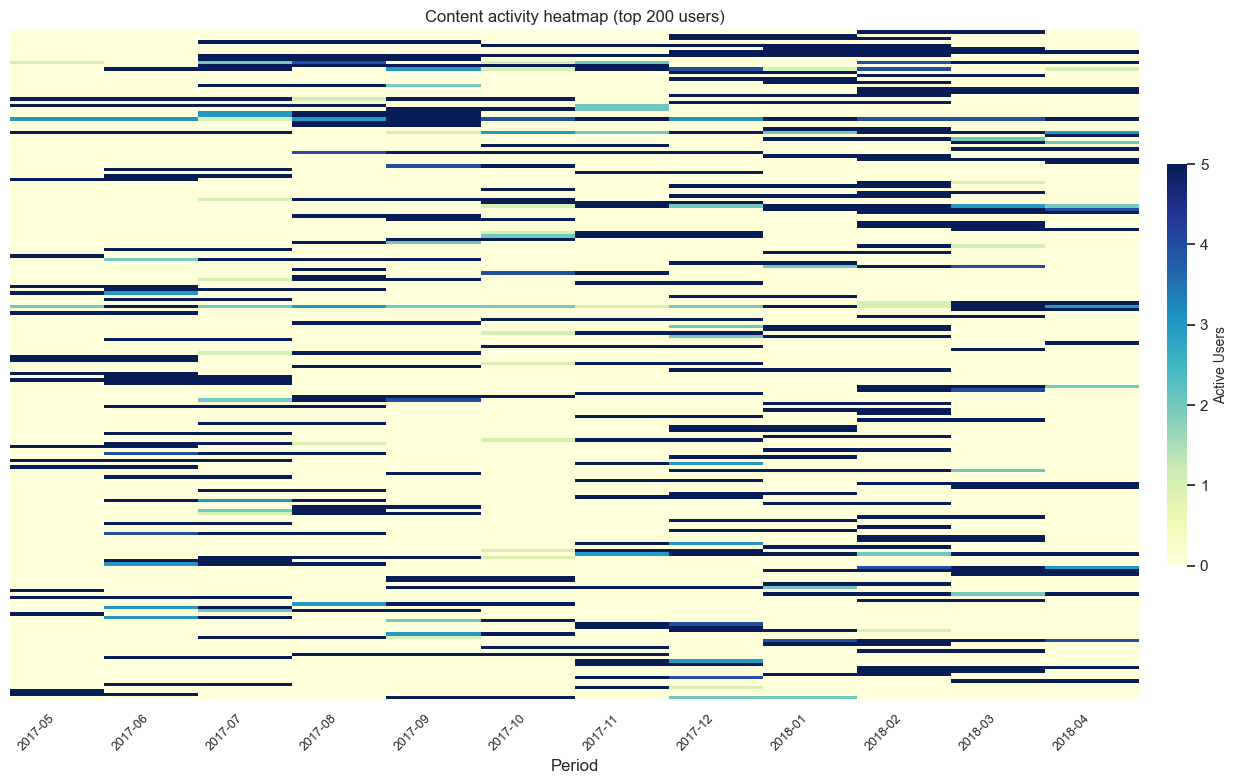

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Improved heatmap: show only top-N most active users to improve readability
# compute user activity and subset
user_activity = content_matrix_dataframe.sum(axis=1).sort_values(ascending=False)
top_n = 200  # regola questo valore per presentazioni diverse
subset = content_matrix_dataframe.loc[user_activity.index[:top_n]] if len(user_activity) > 0 else content_matrix_dataframe

plt.figure(figsize=(14, 8))
ax = sns.heatmap(subset,
                 cmap='YlGnBu',
                 cbar_kws={'label': 'Active Users', 'shrink': 0.6, 'pad': 0.02},
                 vmin=0, vmax=5,
                 yticklabels=False)

ax.set_xlabel('Period')
ax.set_ylabel('')  # keep y-axis label empty for cleaner view
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.title(f'Content activity heatmap (top {min(top_n, subset.shape[0])} users)')

# ensure colorbar label size and layout
cbar = ax.collections[0].colorbar if len(ax.collections) > 0 else None
if cbar is not None:
    cbar.ax.yaxis.label.set_size(10)

plt.tight_layout()
plt.show()

## Distribution Summary

In [32]:
# Build binary active_users_matrix: 1 se content >= 1 in quel period, 0 altrimenti
df_active = data.copy()
df_active['active'] = (df_active['content'].fillna(0) >= 1).astype(int)
df_active = df_active[['user','period','active']].drop_duplicates()

# pivot in matrix (user x period) con valori 1/0
active_users_matrix = (
    df_active.pivot_table(index='user', columns='period', values='active', aggfunc='max')
    .fillna(0).astype(int)
)

print('Active users matrix built: rows=users, cols=periods')
print(active_users_matrix.shape)


Active users matrix built: rows=users, cols=periods
(21440, 12)


In [33]:
# From active_users_matrix compute % of users still active after k months since first activation (k=1..12)
import numpy as np

# ensure columns are PeriodIndex
cols = active_users_matrix.columns

# find first active period per user (NaT if never active)
def first_active_period(row):
    active_cols = [c for c, v in row.items() if int(v) == 1]
    return active_cols[0] if active_cols else pd.NaT

first_active = active_users_matrix.apply(first_active_period, axis=1)

users = active_users_matrix.index.tolist()
n_users = len(users)

rows = []
for k in range(1, 13):
    active_count = 0
    for u in users:
        fa = first_active.loc[u]
        if pd.isna(fa):
            continue
        target = fa + k  # Period + int aggiunge mesi correttamente
        if target in active_users_matrix.columns:
            if active_users_matrix.at[u, target] == 1:
                active_count += 1
        # se target non esiste, l'utente non è considerato attivo per quel k
    pct = (active_count / n_users * 100) if n_users > 0 else np.nan
    rows.append({'months_after_first_activation': k, 'active_count': int(active_count), 'active_pct': pct})

distribution_k = pd.DataFrame(rows).set_index('months_after_first_activation')
print('Percent of users active after k months since first activation:')

# keep results for later use
distribution_k

Percent of users active after k months since first activation:


,active_count,active_pct
months_after_first_activation,,
1,10910,50.886194
2,1311,6.114739
3,202,0.942164
4,75,0.349813
5,43,0.200560
6,28,0.130597
7,18,0.083955
8,11,0.051306
9,6,0.027985


## Monthly Survival Probability

Monthly survival probabilities (k = months since first activation):
    active_count  survival_prob  survival_pct  conditional_retention
k                                                                   
0          21440       1.000000    100.000000                    NaN
1          11166       0.520802     52.080224               0.520802
2           1391       0.064879      6.487873               0.124575
3            234       0.010914      1.091418               0.168224
4             93       0.004338      0.433769               0.397436
5             53       0.002472      0.247201               0.569892
6             35       0.001632      0.163246               0.660377
7             22       0.001026      0.102612               0.628571
8             14       0.000653      0.065299               0.636364
9             10       0.000466      0.046642               0.714286
10             9       0.000420      0.041978               0.900000
11             8       0.000373    

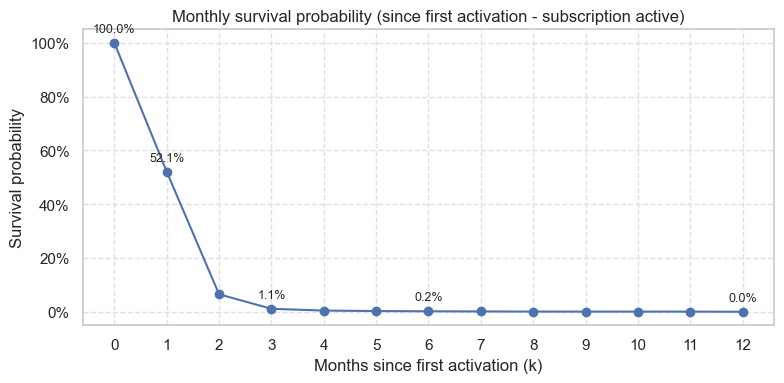

,active_count,survival_prob,survival_pct,conditional_retention
k,,,,
0,21440,1.000000,100.000000,NaN
1,11166,0.520802,52.080224,0.520802
2,1391,0.064879,6.487873,0.124575
3,234,0.010914,1.091418,0.168224
4,93,0.004338,0.433769,0.397436
5,53,0.002472,0.247201,0.569892
6,35,0.001632,0.163246,0.660377
7,22,0.001026,0.102612,0.628571
8,14,0.000653,0.065299,0.636364


In [35]:
# Monthly survival probabilities (k = 0..12) since first activation (improved plotting)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Define 'active' using subscription == 1 (fallback to content if subscription missing)
if 'subscription' in data.columns:
    df_active = data[data['subscription'] == 1][['user','period']].drop_duplicates()
else:
    # fallback behavior: use content>=1 but warn the user
    import warnings
    warnings.warn("Column 'subscription' not found in data — falling back to content>=1 for active definition.")
    df_active = data.copy()
    df_active['active'] = (df_active['content'].fillna(0) >= 1).astype(int)
    df_active = df_active[df_active['active'] == 1][['user','period']].drop_duplicates()

# First active period per user
if df_active.empty:
    print('No active subscriptions found. Check data/subscription values.')
    # create empty survival_df to avoid downstream errors
    survival_df = pd.DataFrame(columns=['k','active_count','survival_prob','survival_pct']).set_index('k')
else:
    first_active = df_active.groupby('user')['period'].min()
    users = first_active.index.to_numpy()
    n_users = len(users)

    rows = []
    for k in range(0, 13):
        target_periods = (first_active + k).reindex(users)
        left = pd.DataFrame({'user': users, 'target_period': target_periods.values})
        merged = left.merge(df_active, left_on=['user','target_period'], right_on=['user','period'], how='left', indicator=True)
        active_count = int((merged['_merge'] == 'both').sum())
        survival_prob = active_count / n_users if n_users > 0 else np.nan
        rows.append({
            'k': k,
            'active_count': active_count,
            'survival_prob': survival_prob,
            'survival_pct': survival_prob * 100 if not np.isnan(survival_prob) else np.nan,
        })

    survival_df = pd.DataFrame(rows).set_index('k')
    # Conditional month-to-month retention
    survival_df['conditional_retention'] = survival_df['survival_prob'] / survival_df['survival_prob'].shift(1)

    print('Monthly survival probabilities (k = months since first activation):')
    print(survival_df)

    # Improved plot: percent y-axis + annotations on key ks
    plt.figure(figsize=(8,4))
    plt.plot(survival_df.index, survival_df['survival_prob'], marker='o')
    plt.title('Monthly survival probability (since first activation - subscription active)')
    plt.xlabel('Months since first activation (k)')
    plt.ylabel('Survival probability')
    plt.xticks(survival_df.index)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # annotate some key points for communication
    for k in [0,1,3,6,12]:
        if k in survival_df.index and not np.isnan(survival_df.loc[k,'survival_prob']):
            val = survival_df.loc[k,'survival_prob']
            plt.annotate(f"{val*100:.1f}%", (k, val), textcoords='offset points', xytext=(0,8), ha='center', fontsize=9)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# expose survival_df for downstream analysis
survival_df

### Executive Summary

/var/folders/9_/51m0drvn29bc0q_f8x0y62jw0000gn/T/ipykernel_82667/4034299168.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(active_by_period.index.astype(str), rotation=45, ha='right', fontsize=9) if not active_by_period.empty else None
/var/folders/9_/51m0drvn29bc0q_f8x0y62jw0000gn/T/ipykernel_82667/4034299168.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
/var/folders/9_/51m0drvn29bc0q_f8x0y62jw0000gn/T/ipykernel_82667/4034299168.py:202: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


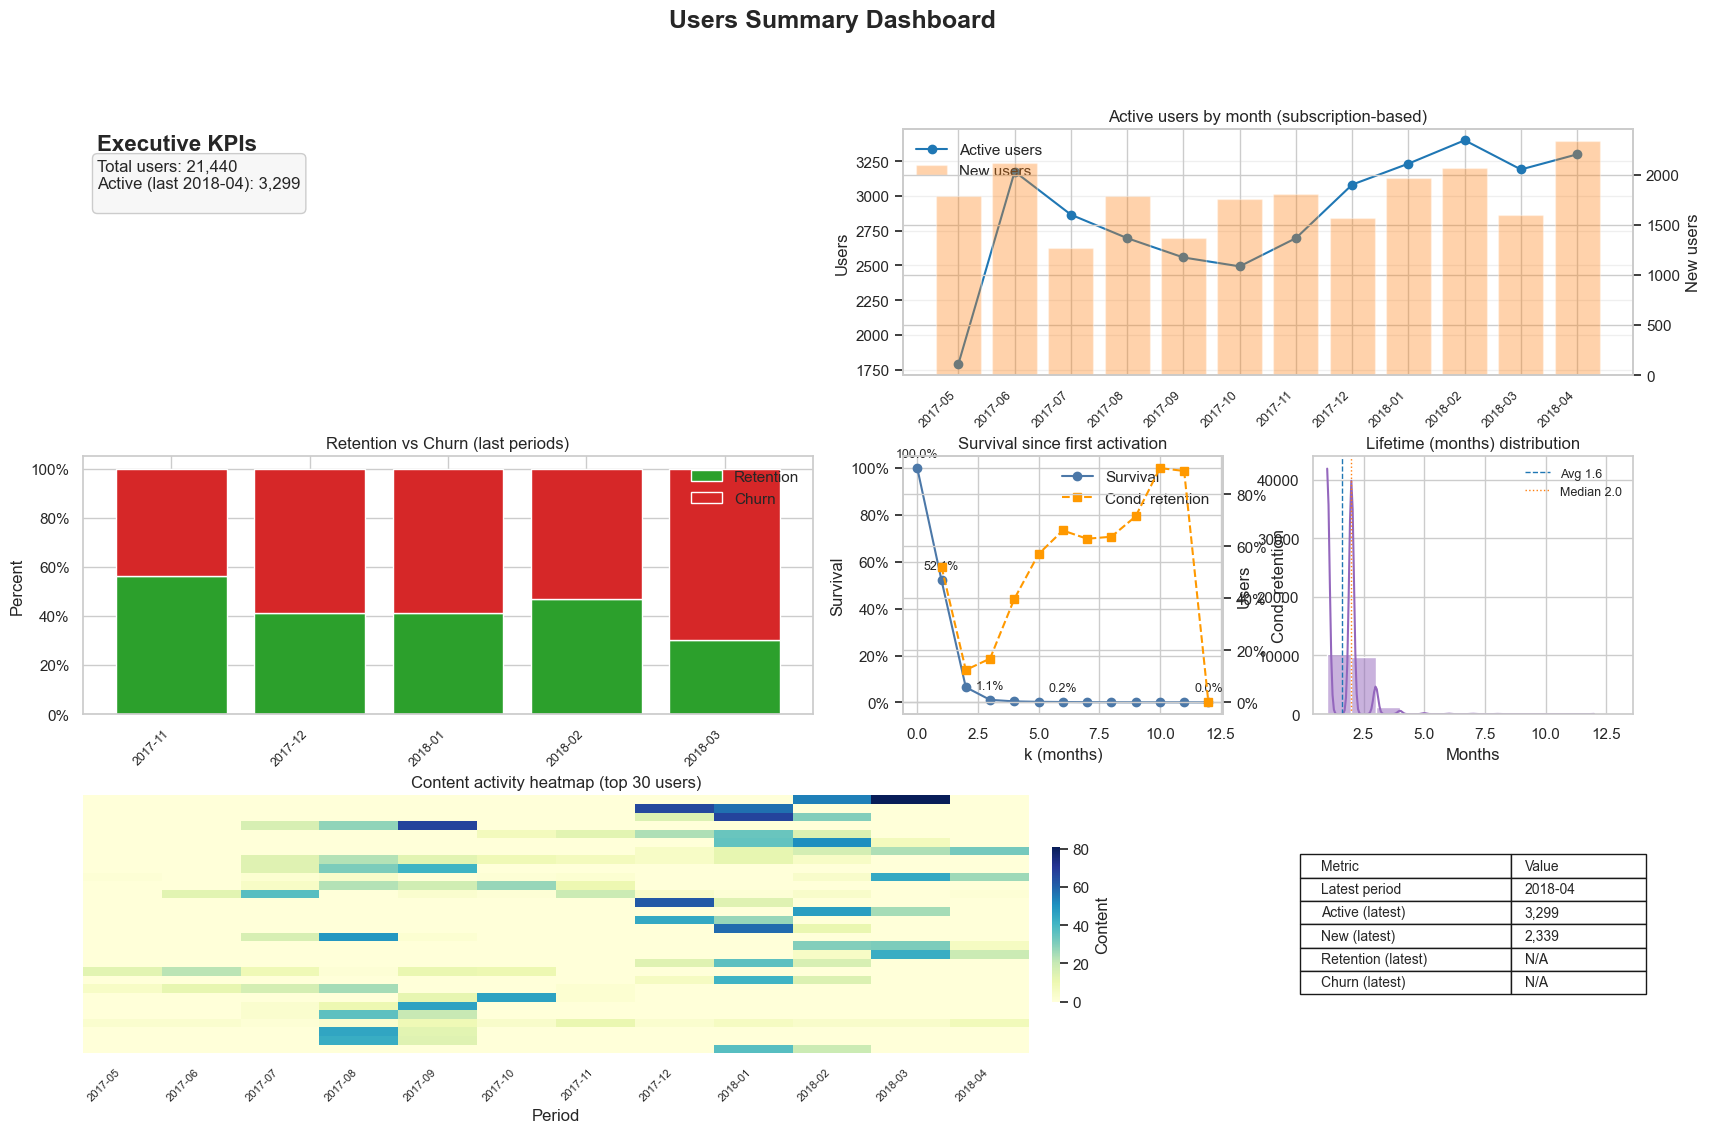

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='whitegrid')

# ---------- KPI base ----------
df = data.copy()
df = df.dropna(subset=['user','date']).copy()
df['user'] = df['user'].astype(str).str.strip()
if 'period' not in df.columns:
    df['period'] = df['date'].dt.to_period('M')

# Attivi per 'subscription' (fallback a content>=1 se non disponibile)
if 'subscription' in df.columns:
    active_mask = (df['subscription'] == 1)
else:
    active_mask = (df['content'].fillna(0) >= 1)

active_by_period = df[active_mask].groupby('period')['user'].nunique().sort_index()
first_sub_period = df[active_mask].groupby('user')['period'].min() if not df[active_mask].empty else pd.Series(dtype='object')
new_by_period = first_sub_period.value_counts().sort_index() if not first_sub_period.empty else pd.Series(dtype='int')

# Lifetime (mesi)
first_seen = df.groupby('user')['date'].min()
last_seen = df.groupby('user')['date'].max()
lifetime_months = ((last_seen.dt.year - first_seen.dt.year) * 12 + (last_seen.dt.month - first_seen.dt.month) + 1).dropna()
avg_life = float(lifetime_months.mean()) if len(lifetime_months) else np.nan
med_life = float(lifetime_months.median()) if len(lifetime_months) else np.nan

total_users = int(df['user'].nunique())
last_p = df['period'].max() if 'period' in df.columns else pd.NaT
active_last = int(df[(df['period'] == last_p) & active_mask]['user'].nunique()) if pd.notna(last_p) else 0
new_last = int((first_sub_period == last_p).sum()) if not first_sub_period.empty and pd.notna(last_p) else 0

# ---------- Churn/Retention per period (se non esiste churn_dataframe lo ricalcolo) ----------
def compute_churn(df_in):
    sub_by_p = (df_in[active_mask].groupby('period')['user'].unique().sort_index())
    rows = []
    periods = list(sub_by_p.index)
    for p in periods:
        curr = set(sub_by_p.loc[p])
        total = len(curr)
        nxt_p = p + 1
        if nxt_p in sub_by_p.index:
            nxt = set(sub_by_p.loc[nxt_p])
            retained = len(curr & nxt)
            churned = len(curr - nxt)
            rr = retained/total if total else np.nan
            cr = churned/total if total else np.nan
        else:
            retained = np.nan; churned = np.nan; rr = np.nan; cr = np.nan
        rows.append({'period': p,'total_users': total,'retained_users': retained,'churned_users': churned,'retention_rate': rr,'churn_rate': cr})
    out = pd.DataFrame(rows).set_index('period').sort_index()
    out['retention_rate_pct'] = (out['retention_rate']*100).round(1)
    out['churn_rate_pct'] = (out['churn_rate']*100).round(1)
    return out

churn_df = churn_dataframe.copy() if 'churn_dataframe' in globals() else compute_churn(df)

# ---------- Survival probabilities (k = 0..12) con subscription attiva ----------
def compute_survival(df_in, k_max=12):
    act = df_in[active_mask][['user','period']].drop_duplicates()
    if act.empty:
        return pd.DataFrame(columns=['k','active_count','survival_prob','survival_pct','conditional_retention']).set_index('k')
    fa = act.groupby('user')['period'].min()
    users = fa.index.to_numpy()
    n = len(users)
    rows = []
    for k in range(0, k_max+1):
        targets = (fa + k).reindex(users)
        left = pd.DataFrame({'user': users, 'target_period': targets.values})
        merged = left.merge(act, left_on=['user','target_period'], right_on=['user','period'], how='left', indicator=True)
        active_count = int((merged['_merge'] == 'both').sum())
        prob = active_count/n if n > 0 else np.nan
        rows.append({'k': k,'active_count': active_count,'survival_prob': prob,'survival_pct': prob*100 if not np.isnan(prob) else np.nan})
    surv = pd.DataFrame(rows).set_index('k')
    surv['conditional_retention'] = surv['survival_prob'] / surv['survival_prob'].shift(1)
    return surv

surv_df = survival_df.copy() if 'survival_df' in globals() else compute_survival(df, 12)

# ---------- Heatmap content (fallback se non presente) ----------
if 'content_matrix_dataframe' in globals():
    content_mat = content_matrix_dataframe.copy()
else:
    tmp = df[['user','period','content']].drop_duplicates() if 'content' in df.columns else df[['user','period']].assign(content=0)
    content_mat = tmp.pivot(index='user', columns='period', values='content').fillna(0)

user_activity = content_mat.sum(axis=1).sort_values(ascending=False) if content_mat.shape[0] else pd.Series(dtype='float')
top_n = 30
subset_hm = content_mat.loc[user_activity.index[:top_n]] if len(user_activity) else content_mat

# ---------- Figura complessa ----------
plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(3, 4, height_ratios=[1.05, 1.1, 1.1], width_ratios=[1,1,1,1], wspace=0.28, hspace=0.32)

# A) KPI box
ax0 = plt.subplot(gs[0, 0:2])
ax0.axis('off')
kpi_text = (
    f"Total users: {total_users:,}\n"
    f"Active (last {last_p}): {active_last:,}\n" if pd.notna(last_p) else f"Active (last): {active_last:,}\n"
    f"New (last {last_p}): {new_last:,}\n" if pd.notna(last_p) else f"New (last): {new_last:,}\n"
    f"Avg lifetime: {avg_life:.1f} mo\n" if not np.isnan(avg_life) else "Avg lifetime: N/A\n"
    f"Median lifetime: {med_life:.1f} mo\n" if not np.isnan(med_life) else "Median lifetime: N/A\n"
    f"Latest retention: {churn_df['retention_rate_pct'].dropna().iloc[-1]:.1f}%\n" if not churn_df.empty and pd.notna(churn_df['retention_rate_pct'].iloc[-1]) else "Latest retention: N/A\n"
    f"Latest churn: {churn_df['churn_rate_pct'].dropna().iloc[-1]:.1f}%" if not churn_df.empty and pd.notna(churn_df['churn_rate_pct'].iloc[-1]) else "Latest churn: N/A"
)
ax0.text(0.02, 0.98, "Executive KPIs", fontsize=16, fontweight='bold', va='top')
ax0.text(0.02, 0.88, kpi_text, fontsize=12, va='top', bbox=dict(boxstyle='round', facecolor='#f7f7f7', edgecolor='#cccccc'))

# B) Active vs New (time series + twin axis)
ax1 = plt.subplot(gs[0, 2:4])
if not active_by_period.empty:
    ax1.plot(active_by_period.index.astype(str), active_by_period.values, color='#1f77b4', marker='o', label='Active users')
ax1.set_title('Active users by month (subscription-based)')
ax1.set_xticklabels(active_by_period.index.astype(str), rotation=45, ha='right', fontsize=9) if not active_by_period.empty else None
ax1.set_ylabel('Users')
ax1.grid(True, axis='y', alpha=0.3)
ax1b = ax1.twinx()
if not new_by_period.empty:
    ax1b.bar(new_by_period.index.astype(str), new_by_period.values, color='#ff7f0e', alpha=0.35, label='New users')
ax1b.set_ylabel('New users')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc='upper left', frameon=False)

# C) Retention vs Churn (ultimi 6 periodi, stacked)
ax2 = plt.subplot(gs[1, 0:2])
if not churn_df.empty:
    last_n = churn_df.tail(min(6, len(churn_df)))
    x = last_n.index.astype(str)
    ax2.bar(x, last_n['retention_rate_pct'], color='#2ca02c', label='Retention')
    ax2.bar(x, last_n['churn_rate_pct'], bottom=last_n['retention_rate_pct'], color='#d62728', label='Churn')
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter(100.0))
    ax2.set_title('Retention vs Churn (last periods)')
    ax2.set_ylabel('Percent')
    ax2.legend(frameon=False)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)

# D) Survival curve + conditional retention (second y)
ax3 = plt.subplot(gs[1, 2])
if not surv_df.empty:
    ax3.plot(surv_df.index, surv_df['survival_prob'], color='#4C78A8', marker='o', label='Survival')
    ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax3.set_title('Survival since first activation')
    ax3.set_xlabel('k (months)')
    ax3.set_ylabel('Survival')
    # Annotazioni chiave
    for k in [0,1,3,6,12]:
        if k in surv_df.index and not np.isnan(surv_df.loc[k,'survival_prob']):
            v = surv_df.loc[k,'survival_prob']
            ax3.annotate(f"{v*100:.1f}%", (k, v), textcoords='offset points', xytext=(0,8), ha='center', fontsize=9)
    ax3b = ax3.twinx()
    ax3b.plot(surv_df.index, surv_df['conditional_retention'], color='#FF9900', marker='s', linestyle='--', label='Cond. retention')
    ax3b.set_ylabel('Cond. retention')
    ax3b.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    l1, lab1 = ax3.get_legend_handles_labels()
    l2, lab2 = ax3b.get_legend_handles_labels()
    ax3.legend(l1+l2, lab1+lab2, loc='upper right', frameon=False)

# E) Lifetime distribution (hist + KDE)
ax4 = plt.subplot(gs[1, 3])
if len(lifetime_months):
    sns.histplot(lifetime_months, bins=range(1, int(lifetime_months.max())+2), kde=True, color='#9467bd', ax=ax4)
    ax4.set_title('Lifetime (months) distribution')
    ax4.set_xlabel('Months')
    ax4.set_ylabel('Users')
    # Linee media e mediana
    if not np.isnan(avg_life): ax4.axvline(avg_life, color='#1f77b4', linestyle='--', linewidth=1, label=f'Avg {avg_life:.1f}')
    if not np.isnan(med_life): ax4.axvline(med_life, color='#ff7f0e', linestyle=':', linewidth=1, label=f'Median {med_life:.1f}')
    ax4.legend(frameon=False, fontsize=9)

# F) Heatmap contenuti (top 30 utenti)
ax5 = plt.subplot(gs[2, 0:3])
if subset_hm.shape[0] > 0 and subset_hm.shape[1] > 0:
    hm = sns.heatmap(subset_hm, cmap='YlGnBu', cbar_kws={'label': 'Content', 'shrink': 0.6, 'pad': 0.02},
                     vmin=np.nanmin(subset_hm.values), vmax=np.nanmax(subset_hm.values) if np.nanmax(subset_hm.values)>0 else 1,
                     yticklabels=False, ax=ax5)
    ax5.set_title(f'Content activity heatmap (top {min(top_n, subset_hm.shape[0])} users)')
    ax5.set_xlabel('Period')
    plt.setp(ax5.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# G) Tabella ultimo periodo
ax6 = plt.subplot(gs[2, 3])
ax6.axis('off')
table_data = [
    ['Metric','Value'],
    ['Latest period', str(last_p) if pd.notna(last_p) else 'N/A'],
    ['Active (latest)', f"{active_last:,}"],
    ['New (latest)', f"{new_last:,}"],
    ['Retention (latest)', f"{churn_df['retention_rate_pct'].dropna().iloc[-1]:.1f}%" if not churn_df.empty and pd.notna(churn_df['retention_rate_pct'].iloc[-1]) else 'N/A'],
    ['Churn (latest)', f"{churn_df['churn_rate_pct'].dropna().iloc[-1]:.1f}%" if not churn_df.empty and pd.notna(churn_df['churn_rate_pct'].iloc[-1]) else 'N/A'],
]
tbl = ax6.table(cellText=table_data, loc='center', cellLoc='left', colWidths=[0.55, 0.35])
tbl.auto_set_font_size(False); tbl.set_fontsize(10); tbl.scale(1.2, 1.4)

plt.suptitle('Users Summary Dashboard', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()